# <span style="color:darkorange"> Exercises 06 (NSL) </span>
# <span style="color:darkorange"> 06.1: 1D Ising model </span>

The simulation of the 1D Ising model for $N$ spins, arranged so that they obey periodic boundary conditions, is performed with two different methods that allow to sample according to the <font color="darkorange">Boltzmann equilibrium probability distribution</font> for the states of a generic system in weak thermal contact with a huge environment:

$$
p_{\mu}=p(E_\mu) = \frac{e^{-\beta E_{\mu}}}{Z}, 
$$

where $\mu$ labels a configuration, $E_{\mu}$ its energy and $Z$ is a normalization constant.

* **Method 1:** <font color="darkorange">Metropolis</font> sampling algorithm

    The <font color="darkorange">candidate</font> for the new configuration $\mu_{new}$ is chosen uniformly at random within the set of all configurations in which <font color="darkorange">all spins but one</font> (chosen uniformly, at random) <font color="darkorange">are the same</font> as in $\mu=\mu_{old}$.
    The probability for establishing whether to <font color="darkorange">accept or reject</font> the move depends on the <font color="darkorange">energy change</font> between configurations: 
    
    $$
    A\left(\mu_{old} \rightarrow \mu_{new}\right) =
    \min \{ 1 , \exp\left( -\beta\left(E_{new}-E_{old}\right) \right) \}.
    $$


* **Method 2:** <font color="darkorange">Gibbs</font> sampling algorithm
    
    The Gibbs sampling basically samples a new value for the $k$-th spin at time $t+1$ ($new$), by sampling according to the <font color="darkorange">conditional probability where all other spins are fixed</font> to their value at time $t$ ($old$):
    
    $$
    T\left(\mu_{new}|\mu_{old}\right) = 
    p_{1|n-1}\left( s^{t+1}_k | {s^{t}_i, i \neq k} \right) \Pi_{i \neq k} \delta\left(s^{t+1}_{i}-s^{t}_{i} \right) =
    p_{1|n-1}\left( s^{new}_k | {s^{old}_i, i \neq k} \right) \Pi_{i \neq k} \delta\left(s^{new}_{i}-s^{old}_{i} \right) .
    $$
    
To switch between the two methods, the code requires the proper setting of `ReadInput >> metro` in its <font color="darkorange">run card</font>, called `input`.
______________________________________________________________________

### Equilibration and restart

As usual, <font color="darkorange">to avoid systematic errors</font>, measurements should be taken only after the the equilibration time, which can be detected with the stabilization of the plotted instantaneous quantities. By using `ReadInput >> restart = 0`, the starting configuration is chosen as a random coin toss with probability $1/2$ for every spin site; instead, the setting `ReadInput >> restart = 1` allows to <font color="darkorange">start a simulation from the equilibrium configuration</font>, priorly saved in `config.final`.

The purpose of the code is calculating the following physical quantities (if per spin, they are to be divided by $N$): $U(N,T)$, $C(N,T)$, $\chi(N,T)$ and $M(N,T,h)$. In particular, the plots show:

1. $U(N,T) = \langle H \rangle_{h=0}$

2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 

3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$

4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5,2.0\right]$, for a system of $N=50$ spins with coupling constant $J=1$.

**Notes:**

* a Monte Carlo step will consist in <font color="darkorange">trying to flip all spins in one time</font>;

* the calculation of $C(N,T)$ is the most subtle, because it is <font color="darkorange">not defined instantaneously</font>, but only at the end of a block; on the contrary, the other observables are defined at each step;

* for managing the problem of <font color="darkorange">correlated samplings</font> while estimating quantities and their statistical uncertainties, data blocking is implemented.

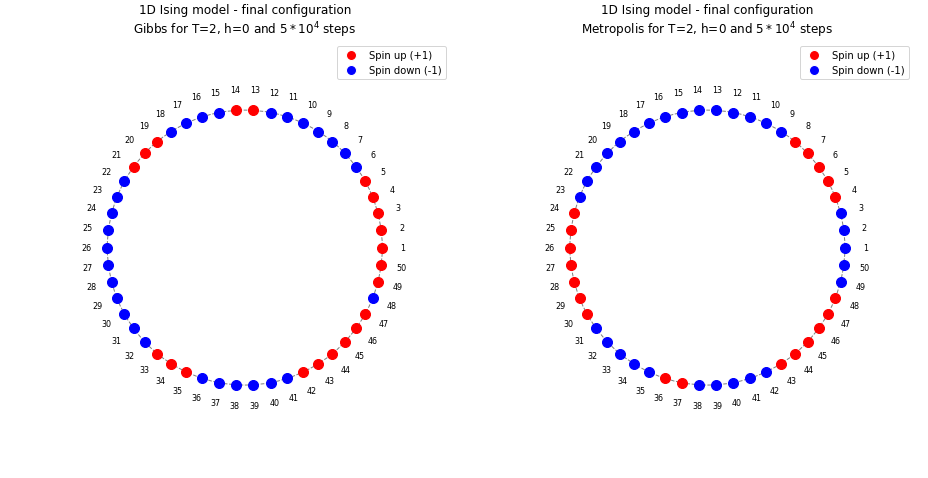

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# FUNCTIONS DEFINITION

# Step 1: Read the configuration file
def read_config(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    return [int(line.strip()) for line in lines]

# Step 2: Generate positions in a circle
def generate_circle_positions(n):
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)
    return x, y

# Step 3: Draw the particles
def draw_particles(ax, x, y, colors, labels, title):
    ax.set_aspect('equal')
    
    # Set a radial offset for labels
    label_offset = 1.15  # Adjust this value to control the distance of labels from the center
    
    # Draw particles with labels
    for (xi, yi, color, label) in zip(x, y, colors, labels):
        ax.plot(xi, yi, 'o', color=color, markersize=10)
        
        # Calculate the position for the labels
        label_x = xi * label_offset
        label_y = yi * label_offset
        ax.text(label_x, label_y, label, color='black', ha='center', va='center', fontsize=8)
        
    # Draw circumference
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)
    
    # Set limits and title
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axis('off')
    ax.set_title(title)
    
    # Add legend
    red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Spin up (+1)', markerfacecolor='red', markersize=10)
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Spin down (-1)', markerfacecolor='blue', markersize=10)
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')

# FIGURE GENERATION

# Read configurations
config_gibbs = read_config('plots_part1/config_final_with_h_0_and_T_2_GIBBS.txt')
config_metro = read_config('plots_part1/config_final_with_h_0_and_T_2_METRO.txt')

# Determine colors and labels
colors_gibbs = ['red' if val == 1 else 'blue' for val in config_gibbs]
labels_gibbs = [str(i + 1) for i in range(len(config_gibbs))]

colors_metro = ['red' if val == 1 else 'blue' for val in config_metro]
labels_metro = [str(i + 1) for i in range(len(config_metro))]

# Generate positions
x_gibbs, y_gibbs = generate_circle_positions(len(config_gibbs))
x_metro, y_metro = generate_circle_positions(len(config_metro))

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))

# Draw particles for GIBBS
draw_particles(ax1, x_gibbs, y_gibbs, colors_gibbs, labels_gibbs, '1D Ising model - final configuration\nGibbs for T=2, h=0 and $5*10^4$ steps')

# Draw particles for METRO
draw_particles(ax2, x_metro, y_metro, colors_metro, labels_metro, '1D Ising model - final configuration\nMetropolis for T=2, h=0 and $5*10^4$ steps')

# Show the plot
plt.tight_layout()
plt.show()

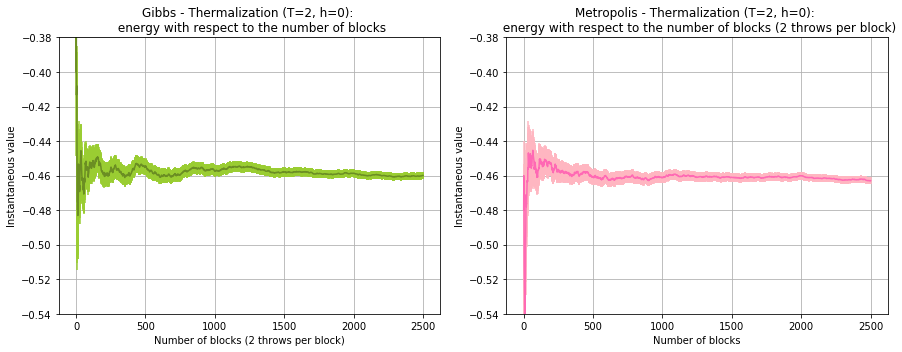

In [10]:
import matplotlib.pyplot as plt

# Function to read data from the file
def read_data(file_path):
    n_blk = []
    instant = []
    error_inst = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            n_blk.append(float(parts[0]))
            instant.append(float(parts[2]))
            error_inst.append(float(parts[3]))
    return n_blk, instant, error_inst

# Read the data
n_blk_gibbs, instant_gibbs, error_inst_gibbs = read_data('plots_part1/thermalization.GIBBS')
n_blk_metro, instant_metro, error_inst_metro = read_data('plots_part1/thermalization.METRO')

# Create a subplot with 1 row and 2 columns
plt.figure(figsize=(13, 5))

# Plot for GIBBS data
plt.subplot(1, 2, 1)
plt.errorbar(n_blk_gibbs, instant_gibbs, error_inst_gibbs, linestyle='-', ecolor='yellowgreen', color='olivedrab')
plt.xlabel('Number of blocks (2 throws per block)')
plt.ylabel('Instantaneous value')
plt.ylim(-0.54,-0.38)
plt.title('Gibbs - Thermalization (T=2, h=0): \n energy with respect to the number of blocks')
plt.grid(True)

# Plot for METRO data
plt.subplot(1, 2, 2)
plt.errorbar(n_blk_metro, instant_metro, error_inst_metro, linestyle='-', ecolor='lightpink', color='hotpink')
plt.xlabel('Number of blocks')
plt.ylabel('Instantaneous value')
plt.ylim(-0.54,-0.38)
plt.title('Metropolis - Thermalization (T=2, h=0): \n energy with respect to the number of blocks (2 throws per block)')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


______________

### Estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties

Each calculation of the physical quantities at a given temperature (one for each of the $N_{points}=100$ points on the plots) is carried out by performing $M=10^5$ MC steps, divided into $200$ blocks of $2000$ moves each. For each point, the $y$-value and its error bar refer to the <font color="darkorange">global average</font> and the <font color="darkorange">global uncertainty</font>, calculated when the <font color="darkorange">last block</font> is completed. 

<font color="darkorange">To avoid equilibrating</font> for every temperature, the code is looped to repeat the measurement while temperature is lowered in steps of $\Delta T = - \left| T_{max}-T_{min} \right|/N_{points}$, starting from the highest temperature $T_{max}=2.0$ to $T_{min}=0.5$: in this way, the <font color="darkorange">last configuration</font> at $T$, which is in proximity of the equilibrated state of $T + \Delta T$ (provided that $\Delta T$ is small), <font color="darkorange">is recycled</font>.

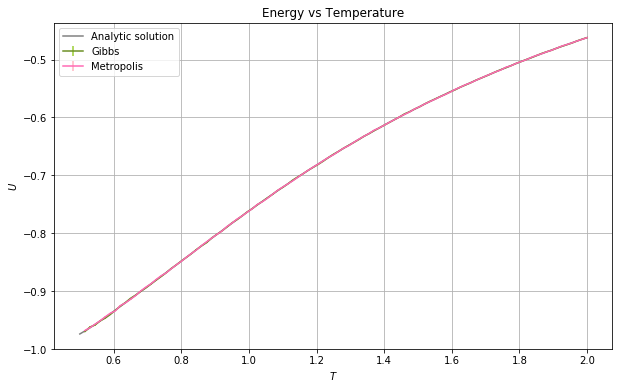

In [16]:
import numpy as np
import matplotlib.pyplot as plt

##################################
# Read data from Gibbs file
##################################

filename_gibbs = 'plot_errorbar_ene.0.isi.fieldOFF.GIBBS'

temperatures_gibbs = []
energies_gibbs = []
errors_gibbs = []

with open(filename_gibbs, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            energy = float(parts[1])
            error = float(parts[2])

            temperatures_gibbs.append(temperature)
            energies_gibbs.append(energy)
            errors_gibbs.append(error)

##################################
# Read data from Metropolis file
##################################

filename_metro = 'plot_errorbar_ene.0.isi.fieldOFF.METRO'

temperatures_metro = []
energies_metro = []
errors_metro = []

with open(filename_metro, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            energy = float(parts[1])
            error = float(parts[2])

            temperatures_metro.append(temperature)
            energies_metro.append(energy)
            errors_metro.append(error)

##################################
# Plotting
##################################

plt.figure(figsize=(10, 6))

# Plot the Gibbs data with error bars
plt.errorbar(temperatures_gibbs, energies_gibbs, yerr=errors_gibbs, linestyle='-', ecolor='yellowgreen', color='olivedrab', label='Gibbs')

# Plot the Metropolis data with error bars
plt.errorbar(temperatures_metro, energies_metro, yerr=errors_metro, linestyle='-', ecolor='lightpink', color='hotpink', label='Metropolis')

##################################
# Generate and plot the analytic solution data
##################################

points = 100
T = np.linspace(0.5, 2.0, num=points)
beta = 1 / T
J = 1.0
Ns = 50
th = np.tanh(J / T)
thN = th**Ns
ch = 1 / th
e = -J * (th + ch * thN) / (1 + thN)

# Plot the analytic solution
plt.plot(T, e, color='gray', label='Analytic solution')

##################################
# Finalize plot
##################################

# Add labels and title
plt.xlabel('$T$')
plt.ylabel('$U$')
plt.title('Energy vs Temperature')
plt.grid()

# Add a legend
plt.legend()

# Show the plot
plt.show()


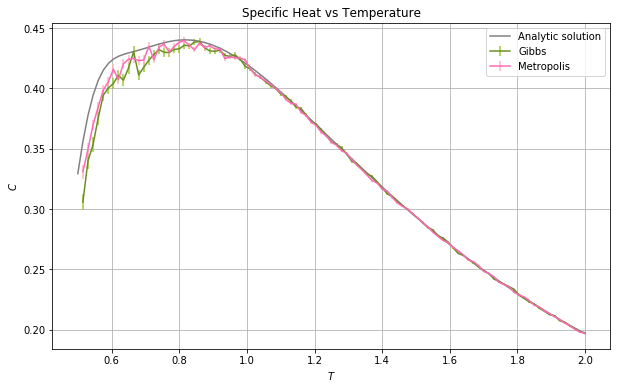

In [17]:
import numpy as np
import matplotlib.pyplot as plt

##################################
# Read data from Gibbs file
##################################

filename_gibbs = 'plot_errorbar_heat.0.isi.fieldOFF.GIBBS'

temperatures_gibbs = []
specific_heats_gibbs = []
errors_gibbs = []

with open(filename_gibbs, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            specific_heat = float(parts[1])
            error = float(parts[2])

            temperatures_gibbs.append(temperature)
            specific_heats_gibbs.append(specific_heat)
            errors_gibbs.append(error)

##################################
# Read data from Metropolis file
##################################

filename_metro = 'plot_errorbar_heat.0.isi.fieldOFF.METRO'

temperatures_metro = []
specific_heats_metro = []
errors_metro = []

with open(filename_metro, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            specific_heat = float(parts[1])
            error = float(parts[2])

            temperatures_metro.append(temperature)
            specific_heats_metro.append(specific_heat)
            errors_metro.append(error)

##################################
# Plotting
##################################

plt.figure(figsize=(10, 6))

# Plot the Gibbs data with error bars
plt.errorbar(temperatures_gibbs, specific_heats_gibbs, yerr=errors_gibbs, linestyle='-', ecolor='yellowgreen', color='olivedrab', label='Gibbs')

# Plot the Metropolis data with error bars
plt.errorbar(temperatures_metro, specific_heats_metro, yerr=errors_metro, linestyle='-', ecolor='lightpink', color='hotpink', label='Metropolis')

##################################
# Generate and plot the analytic solution data
##################################

points = 100
T = np.linspace(0.5, 2.0, num=points)
beta = 1 / T
J = 1.0
Ns = 50
th = np.tanh(J / T)
thN = th**Ns
ch = 1 / th
heat = ((beta * J) ** 2) * (((1 + thN + (Ns - 1) * (th ** 2) + (Ns - 1) * (ch ** 2) * thN) / (1 + thN)) - Ns * ((th + ch * thN) / (1 + thN)) ** 2)

# Plot the analytic solution
plt.plot(T, heat, color='gray', label='Analytic solution')

##################################
# Finalize plot
##################################

# Add labels and title
plt.xlabel('$T$')
plt.ylabel('$C$')
plt.title('Specific Heat vs Temperature')
plt.grid()

# Add a legend
plt.legend()

# Show the plot
plt.show()


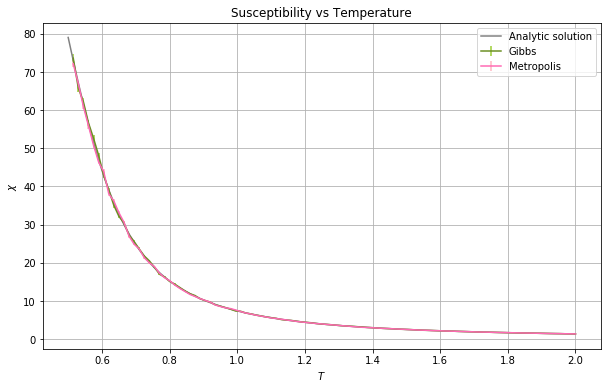

In [18]:
import numpy as np
import matplotlib.pyplot as plt

##################################
# Read data from Gibbs file
##################################

filename_gibbs = 'plot_errorbar_chi.0.isi.fieldOFF.GIBBS'

temperatures_gibbs = []
susceptibilities_gibbs = []
errors_gibbs = []

with open(filename_gibbs, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            susceptibility = float(parts[1])
            error = float(parts[2])

            temperatures_gibbs.append(temperature)
            susceptibilities_gibbs.append(susceptibility)
            errors_gibbs.append(error)

##################################
# Read data from Metropolis file
##################################

filename_metro = 'plot_errorbar_chi.0.isi.fieldOFF.METRO'

temperatures_metro = []
susceptibilities_metro = []
errors_metro = []

with open(filename_metro, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            susceptibility = float(parts[1])
            error = float(parts[2])

            temperatures_metro.append(temperature)
            susceptibilities_metro.append(susceptibility)
            errors_metro.append(error)

##################################
# Plotting
##################################

plt.figure(figsize=(10, 6))

# Plot the Gibbs data with error bars
plt.errorbar(temperatures_gibbs, susceptibilities_gibbs, yerr=errors_gibbs, linestyle='-', ecolor='yellowgreen', color='olivedrab', label='Gibbs')

# Plot the Metropolis data with error bars
plt.errorbar(temperatures_metro, susceptibilities_metro, yerr=errors_metro, linestyle='-', ecolor='lightpink', color='hotpink', label='Metropolis')

##################################
# Generate and plot the analytic solution data
##################################

points = 100
T = np.linspace(0.5, 2.0, num=points)
beta = 1 / T
J = 1.0
Ns = 50
th = np.tanh(J / T)
thN = th**Ns
ch = 1 / th
X = beta * np.exp(2 * beta * J) * (1 - thN) / (1 + thN)

# Plot the analytic solution
plt.plot(T, X, color='gray', label='Analytic solution')

##################################
# Finalize plot
##################################

# Add labels and title
plt.xlabel('$T$')
plt.ylabel('$\chi$')
plt.title('Susceptibility vs Temperature')
plt.grid()

# Add a legend
plt.legend()

# Show the plot
plt.show()


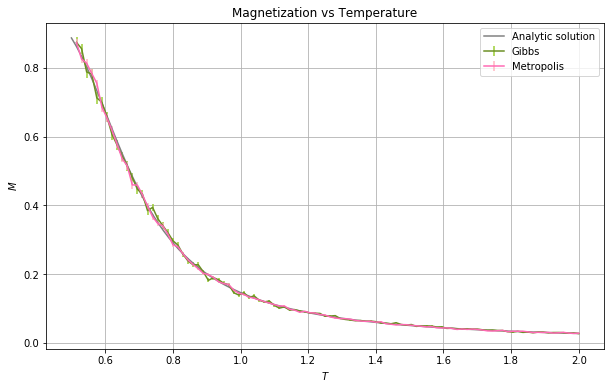

In [19]:
import numpy as np
import matplotlib.pyplot as plt

##################################
# Read data from Gibbs file
##################################

filename_gibbs = 'plot_errorbar_mag.0.isi.fieldON.GIBBS'

temperatures_gibbs = []
magnetizations_gibbs = []
errors_gibbs = []

with open(filename_gibbs, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            magnetization = float(parts[1])
            error = float(parts[2])

            temperatures_gibbs.append(temperature)
            magnetizations_gibbs.append(magnetization)
            errors_gibbs.append(error)

##################################
# Read data from Metropolis file
##################################

filename_metro = 'plot_errorbar_mag.0.isi.fieldON.METRO'

temperatures_metro = []
magnetizations_metro = []
errors_metro = []

with open(filename_metro, 'r') as file:
    for line in file:
        if line.strip():  # Skip any empty lines
            parts = line.split()
            temperature = float(parts[0])
            magnetization = float(parts[1])
            error = float(parts[2])

            temperatures_metro.append(temperature)
            magnetizations_metro.append(magnetization)
            errors_metro.append(error)

##################################
# Plotting
##################################

plt.figure(figsize=(10, 6))

# Plot the Gibbs data with error bars
plt.errorbar(temperatures_gibbs, magnetizations_gibbs, yerr=errors_gibbs, linestyle='-', ecolor='yellowgreen', color='olivedrab', label='Gibbs')

# Plot the Metropolis data with error bars
plt.errorbar(temperatures_metro, magnetizations_metro, yerr=errors_metro, linestyle='-', ecolor='lightpink', color='hotpink', label='Metropolis')

##################################
# Generate and plot the analytic solution data
##################################

points = 100
T = np.linspace(0.5, 2.0, num=points)
J = 1.0
Ns = 50
h = 0.02  # external field
b = 1 / T

l1 = np.exp(b * J) * np.cosh(b * h) + np.sqrt(np.exp(2 * b * J) * np.cosh(b * h) ** 2 - 2 * np.sinh(2 * b * J))
l2 = np.exp(b * J) * np.cosh(b * h) - np.sqrt(np.exp(2 * b * J) * np.cosh(b * h) ** 2 - 2 * np.sinh(2 * b * J))
Z = l1 ** Ns + l2 ** Ns
M = (np.exp(b * J) * np.sinh(b * h) * ((l1 ** (Ns - 1)) * (1 + np.exp(b * J) * np.cosh(b * h) / np.sqrt(np.exp(2 * b * J) * np.cosh(b * h) ** 2 - 2 * np.sinh(2 * b * J))) + 
        (l2 ** (Ns - 1)) * (1 - np.exp(b * J) * np.cosh(b * h) / np.sqrt(np.exp(2 * b * J) * np.cosh(b * h) ** 2 - 2 * np.sinh(2 * b * J)))) / Z)

# Plot the analytic solution
plt.plot(T, M, color='gray', label='Analytic solution')

##################################
# Finalize plot
##################################

# Add labels and title
plt.xlabel('$T$')
plt.ylabel('$M$')
plt.title('Magnetization vs Temperature')
plt.grid()

# Add a legend
plt.legend()

# Show the plot
plt.show()
